# Coup Results Prediction with Classification Models

### Shunji Wan, 11/06/2022

<a id="0"></a> <br>
 ## Table of Contents  
- [Problem Statement](#1)
- [Data Collection and Cleaning](#2)
    1. [The _Coup D'etat Project (CDP)_ Dataset](#3)
    2. [The _Rulers, Elections, and Irregular Governance (REIGN)_ Dataset](#4)
    3. [Data Merging](#5)
    4. [One-Hot Encoding](#6)
- [Exploratory Data Analysis](#7)
- [Feature Engineering](#8)
    1. [Appending Additional Features](#9)
    2. [Missing Values Imputation](#10)
    3. [Feature Selection](#11)
- [Data Modeling](#12)
    1. [Model Training and Evaluation](#13)
    2. [Hyperparameter Tuning](#14)


<a id="1"></a>
## Problem Statement

In modern times, coups refer to the sudden seizure of governmental power through non-institutional ways.

Coups are relatively rare compared with the mundane traditions in everyday politics. They are not sechduled like elections, nor are they publicized beforehand like protests. Coups are secretly planned and executed by only a small faction of the entire population in a country.

Politicians are concerned with coups as they could overthrow regimes and thus lead to geopolitical impacts, and investors care about coups as their local economic interests may be negatively impacted - whatever the results of the coups are, they often entail violence and are hugely impactful on people’s lives, not only in the country where the coup takes place but also in countries that are closely connected to it, economically, politically, or culturally, for coups change what is considered as the norm. The irregularity and the unexpected huge impacts of coups motivate data scientists to uncover patterns in coups.

In our project, we try to predict the outcome of a coup at an early stage, using information that can be acquired at the beginning of the coup, for example, the type of the coup and the population growth in that country in that year. We ask:

- __*Which factors are the most influential in determining whether a result will succeed?*__
- __*Can we make accurate predictions of the coup result with only selected information?*__

Being able to predict whether a coup will succeed at the beginning is important as it allows policymakers to act ahead of time. To this end, we incorporate several data sources. We mainly rely on the __Coup D'etat Project (CDP)__ for a comprehensive list of 943 coups from 1949 to 2019. The CDP dataset distinguishes 10 types of coups that are realized, unrealized or unsubstantiated (in conspiracy only). Then we use the __Rulers, Elections, and Irregular Governance (REIGN)__ dataset to determine specific characteristics of the country where the coup takes place. For example, the length of the government leader’s tenure, the length of democracy, and the time since the last election. Furthermore, we include population data from __Oxford University__ and commodity prices from __World Bank__.

<a id="2"></a>
## Data Collection and Cleaning

In [284]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

Since our data come from various sources, we start with walking through all datasets to get an overview.

<a id="3"></a>
### 1. The _Coup D'etat Project (CDP)_ Data

In [285]:
cdf_df = pd.read_csv("https://raw.githubusercontent.com/sjwan01/coup-results-prediction-with-classification-models/main/data/Coup_Data_v2.0.0.csv")
cdf_df.head(3)

,coup_id,cowcode,country,year,month,day,event_type,unrealized,realized,conspiracy,...,counter,other,noharm,injured,killed,harrest,jailed,tried,fled,exile
0,43910302014,439,Burkina Faso,2014,10,30,coup,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,51605132015,516,Burundi,2015,5,13,attempted,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,48304132006,483,Chad,2006,4,13,attempted,1,0,0,...,0,0,1,0,0,0,0,0,0,0


This dataset includes information concerning where and when the coups took place, results and types of coups.

In [286]:
cdf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   coup_id     943 non-null    object
 1   cowcode     943 non-null    int64 
 2   country     943 non-null    object
 3   year        943 non-null    int64 
 4   month       943 non-null    int64 
 5   day         943 non-null    int64 
 6   event_type  943 non-null    object
 7   unrealized  943 non-null    int64 
 8   realized    943 non-null    int64 
 9   conspiracy  943 non-null    int64 
 10  attempt     943 non-null    int64 
 11  military    943 non-null    int64 
 12  dissident   943 non-null    int64 
 13  rebel       943 non-null    int64 
 14  palace      943 non-null    int64 
 15  foreign     943 non-null    int64 
 16  auto        943 non-null    int64 
 17  resign      943 non-null    int64 
 18  popular     943 non-null    int64 
 19  counter     943 non-null    int64 
 20  other     

Luckily, our __CDP__ dataset does not contain any `null`. Therefore, there is no need for us to worry about missing values.

Next, we print out some descriptive statistics and take a look at ratios of all kinds of coup events.

In [287]:
for i in range(7,21):
    np_col = cdf_df.iloc[:,i].to_numpy()
    num_obs = np.sum(np_col)
    txt = "Ratio of {type} coup events: {numer}/{denom}."
    print(txt.format(type=cdf_df.columns[i],numer=num_obs,denom=len(cdf_df)))

Ratio of unrealized coup events: 517/943.
Ratio of realized coup events: 426/943.
Ratio of conspiracy coup events: 181/943.
Ratio of attempt coup events: 335/943.
Ratio of military coup events: 559/943.
Ratio of dissident coup events: 273/943.
Ratio of rebel coup events: 59/943.
Ratio of palace coup events: 120/943.
Ratio of foreign coup events: 66/943.
Ratio of auto coup events: 32/943.
Ratio of resign coup events: 81/943.
Ratio of popular coup events: 93/943.
Ratio of counter coup events: 19/943.
Ratio of other coup events: 3/943.


We start to clean our dataset. At first, we remove all observations that are conspiracies, because coup instances are our focus. Afterwards, `conspiracy` column can be deleted. Then, we drop the last 8 columns, as they are results of a coup, which cannot help us make prediction ahead.

As for coup types, we remove `other` as it contains too few instances. We further remove `event_type`, `unrealized`, and `attempt`. They are repetitive information as they can all be inferred from `realized`. There is no need for one-hot encoding, as all categorical variables are binary, and their values are either 1 or 0. Now, the __CDP__ dataset should only have coup identifiers, `realized` - which indicates whether a coup succeeded - and binary variables indicating coup types.

In [288]:
cdf_df = cdf_df[cdf_df["conspiracy"]==0].iloc[:,:20]
cdf_df = cdf_df.drop(["event_type","unrealized","conspiracy","attempt"],axis=1).reset_index(drop=True)
cdf_df.head(3)

,coup_id,cowcode,country,year,month,day,realized,military,dissident,rebel,palace,foreign,auto,resign,popular,counter
0,43910302014,439,Burkina Faso,2014,10,30,1,1,0,0,0,0,0,0,1,0
1,51605132015,516,Burundi,2015,5,13,0,1,0,0,0,0,0,0,0,0
2,48304132006,483,Chad,2006,4,13,0,0,1,0,0,0,0,0,0,0


<a id="4"></a>
### 2. The _Rulers, Elections, and Irregular Governance (REIGN)_ Dataset

Next, we start to explore the __REIGN__ dataset. This dataset is very different from the __CDP__ dataset, as it has nothing to do with coups - the __REIGN__ dataset contains information concerning the political leadership, regime characteristics and electoral outcomes for every country around the globe since January 1950. However, it could offer us more features that could help with our coup results prediction.

In [289]:
reign_df = pd.read_csv("https://raw.githubusercontent.com/sjwan01/coup-results-prediction-with-classification-models/main/data/REIGN_2021_8.csv")
reign_df.head(3)

,ccode,country,leader,year,month,elected,age,male,militarycareer,tenure_months,...,lastelection,loss,irregular,political_violence,prev_conflict,pt_suc,pt_attempt,precip,couprisk,pctile_risk
0,2.0,USA,Truman,1950.0,1.0,1.0,66.0,1,0.0,58.0,...,2.639057,5.327876,7.565793,-0.36429,0.0,0.0,0.0,-0.059930,NaN,NaN
1,2.0,USA,Truman,1950.0,2.0,1.0,66.0,1,0.0,59.0,...,2.708050,5.332719,7.566311,-0.36429,0.0,0.0,0.0,-0.113721,NaN,NaN
2,2.0,USA,Truman,1950.0,3.0,1.0,66.0,1,0.0,60.0,...,2.772589,5.337538,7.566829,-0.36429,0.0,0.0,0.0,-0.108042,NaN,NaN


In [290]:
reign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138600 entries, 0 to 138599
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ccode               138600 non-null  float64
 1   country             138600 non-null  object 
 2   leader              138600 non-null  object 
 3   year                138600 non-null  float64
 4   month               138600 non-null  float64
 5   elected             138600 non-null  float64
 6   age                 138600 non-null  float64
 7   male                138600 non-null  int64  
 8   militarycareer      138600 non-null  float64
 9   tenure_months       138600 non-null  float64
 10  government          138600 non-null  object 
 11  gov_democracy       138600 non-null  float64
 12  dem_duration        138600 non-null  float64
 13  anticipation        138600 non-null  float64
 14  ref_ant             138600 non-null  float64
 15  leg_ant             138600 non-nul

This dataset is massive - there are tons of observations as well as features! The codebook of this dataset provides comprehensive definitions all the headers. Please feel free to take a look if you are interested. We noticed that the `government` is categorical, and `couprisk` and `pctile_risk` have `null`s. We keep that in mind and will deal with them after we merge the __CDP__ and the __REIGN__ data.

We further drop `pt_suc` and `pt_attempt` as they indicate whether a coup was attempted and whether it succeeded in a particular month. This informaiton is repetitive. Other than that, all other features look pretty relevant to our question so far.

In [291]:
reign_df = reign_df.drop(['pt_suc','pt_attempt'],axis=1)

<a id="5"></a>
### 3. Data Merging

After exploring the __CDP__ and the __REIGN__ datasets, we merge them using `cowcode`, `country`, `year`, `month` as keys to obtain a comprehensive table that includes coup events with all features. Then, we take a look at our cleaned, merged dataset.

In [292]:
merged_df = cdf_df.merge(reign_df, how='left',
                         left_on=['cowcode','country','year','month'],
                         right_on=['ccode','country','year','month']).drop("ccode",axis=1)
merged_df.head()

,coup_id,cowcode,country,year,month,day,realized,military,dissident,rebel,...,nochange_recent,delayed,lastelection,loss,irregular,political_violence,prev_conflict,precip,couprisk,pctile_risk
0,43910302014,439,Burkina Faso,2014,10,30,1,1,0,0,...,0.0,0.0,3.871201,5.783825,5.616771,-0.361354,0.0,0.207165,0.004781,0.928942
1,51605132015,516,Burundi,2015,5,13,0,1,0,0,...,0.0,0.0,4.094345,4.820282,4.820282,-0.209770,0.0,-0.257498,0.005148,0.941314
2,48304132006,483,Chad,2006,4,13,0,0,1,0,...,0.0,0.0,2.397895,5.220356,2.397895,-0.180390,1.0,0.085150,0.013547,1.044436
3,65102112011,651,Egypt,2011,2,11,1,1,0,0,...,0.0,0.0,3.871201,5.869297,4.189655,-0.364100,0.0,-0.584582,0.000963,0.585180
4,65102112011,651,Egypt,2011,2,11,1,1,0,0,...,0.0,0.0,3.871201,5.869297,4.189655,-0.364100,0.0,-0.584582,0.006321,0.971848


We can notice some problem here: the last two coup events are duplicates!

Why this happened? The leadership of a country changed during coups. Because Mohamed Hussein Tantawi ousted the former President of Egypt Hosni Mubarak in the coup on February 11th, 2011, for instance, the same coup record will present in our merged dataset twice. To address this issue, if there are observations with identical `coup_id`s, we keep the first and remove others.

In [293]:
def remove_duplicates(d):
    
    coup_id_lst = [] # store unique ids found so far
    row_lst = []     # lst of indices of rows with unique ids
    
    for i in range(0,len(d)):
        coup_id = d.loc[i,"coup_id"]
        if coup_id not in coup_id_lst: # if not duplicate
            coup_id_lst.append(coup_id)
            row_lst.append(i)
            
    return d.iloc[row_lst,:].reset_index(drop=True)

In [294]:
unique_df = remove_duplicates(merged_df)

Compare the `coup_id` columns of both `cdf_df` and `unique_df`.

If return true, we successfully merged two tables!

In [295]:
if cdf_df["coup_id"].equals(unique_df["coup_id"]):
    print("We merged the tables! There are in total {num} observations of coup events.".format(num=len(unique_df)))

We merged the tables! There are in total 762 observations of coup events.


<a id="6"></a>
### 4. One-Hot Encoding

We recall that there is one categorical variable in our dataset - `government`. For data science in Python, we need to handle categorical variables with one-hot encoding. Before that, we at first visualize the distribution of these categories and their relationship with `realized`.

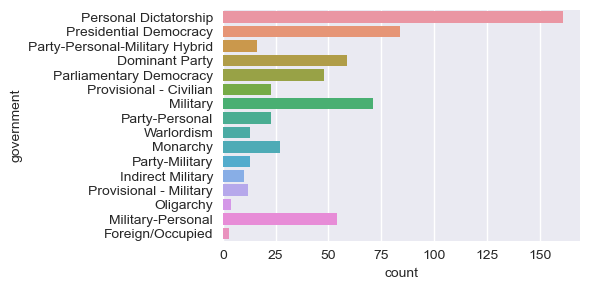

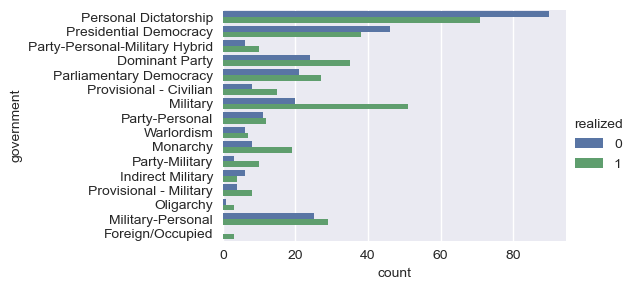

In [296]:
sns.catplot(data=unique_df,y="government",kind="count",height=3,aspect=2)
sns.catplot(data=unique_df,y="government",hue='realized',kind="count",height=3,aspect=2)

Based on the plots, we noticed that some categories are very rare. If we keep them as binary variables after one-hot encoding, it may add unnecessary dimensionality to our data, and we probably do not want to drop them, either - as we will lose many observations.

A solution to this is create another category called `Other` and put those rare categories into it. We may define categories with fewer than 20 instances as "rare" categories. Given this, we manipulate and visualize our data as follows.

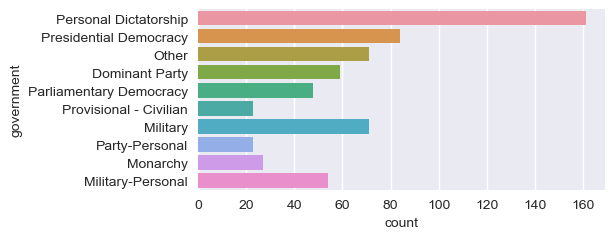

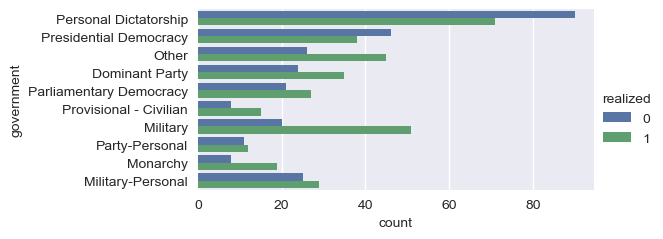

In [297]:
unique_df = unique_df.replace({i:'Other' for i in 
                                ['Party-Personal-Military Hybrid','Warlordism',
                                 'Party-Military','Indirect Military','Provisional - Military',
                                 'Oligarchy','Foreign/Occupied']})

sns.catplot(data=unique_df,y="government",kind="count",height=2.5,aspect=2.5)
sns.catplot(data=unique_df,y="government",hue='realized',kind="count",height=2.5,aspect=2.5)

The categorical data look way more balanced now! Next, we process the dataset using one-hot encoding as follows. After transforming the categorical variable into numerous binary variables, we drop the `leader` and the `government` columns as they are redundant.

In [298]:
one_hot_encoder = OneHotEncoder()
categorical_vars = ['government']

encoder_vars_array = one_hot_encoder.fit_transform(unique_df[categorical_vars])
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

encoder_vars_df = pd.DataFrame(encoder_vars_array.toarray(), columns=encoder_feature_names)
unique_df = pd.concat([unique_df.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis=1)
unique_df = unique_df.drop(['government','leader'], axis=1) 
unique_df.head()

,coup_id,cowcode,country,year,month,day,realized,military,dissident,rebel,...,government_Military,government_Military-Personal,government_Monarchy,government_Other,government_Parliamentary Democracy,government_Party-Personal,government_Personal Dictatorship,government_Presidential Democracy,government_Provisional - Civilian,government_nan
0,43910302014,439,Burkina Faso,2014,10,30,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,51605132015,516,Burundi,2015,5,13,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,48304132006,483,Chad,2006,4,13,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,65102112011,651,Egypt,2011,2,11,1,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65107032013,651,Egypt,2013,7,3,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


So far, except the first 6 features are identifiers of events and `realized` is the target variable, all other features are all potentital candidates for predictors.

<a id="7"></a>
## Exploratory Data Analysis

After merging, we can start to explore the relationship between the target variable `realized` and other features. We may visualize the relationship between `realized` and each one of these features (excluding government types, as we have done so) as appropriate to better understand them.

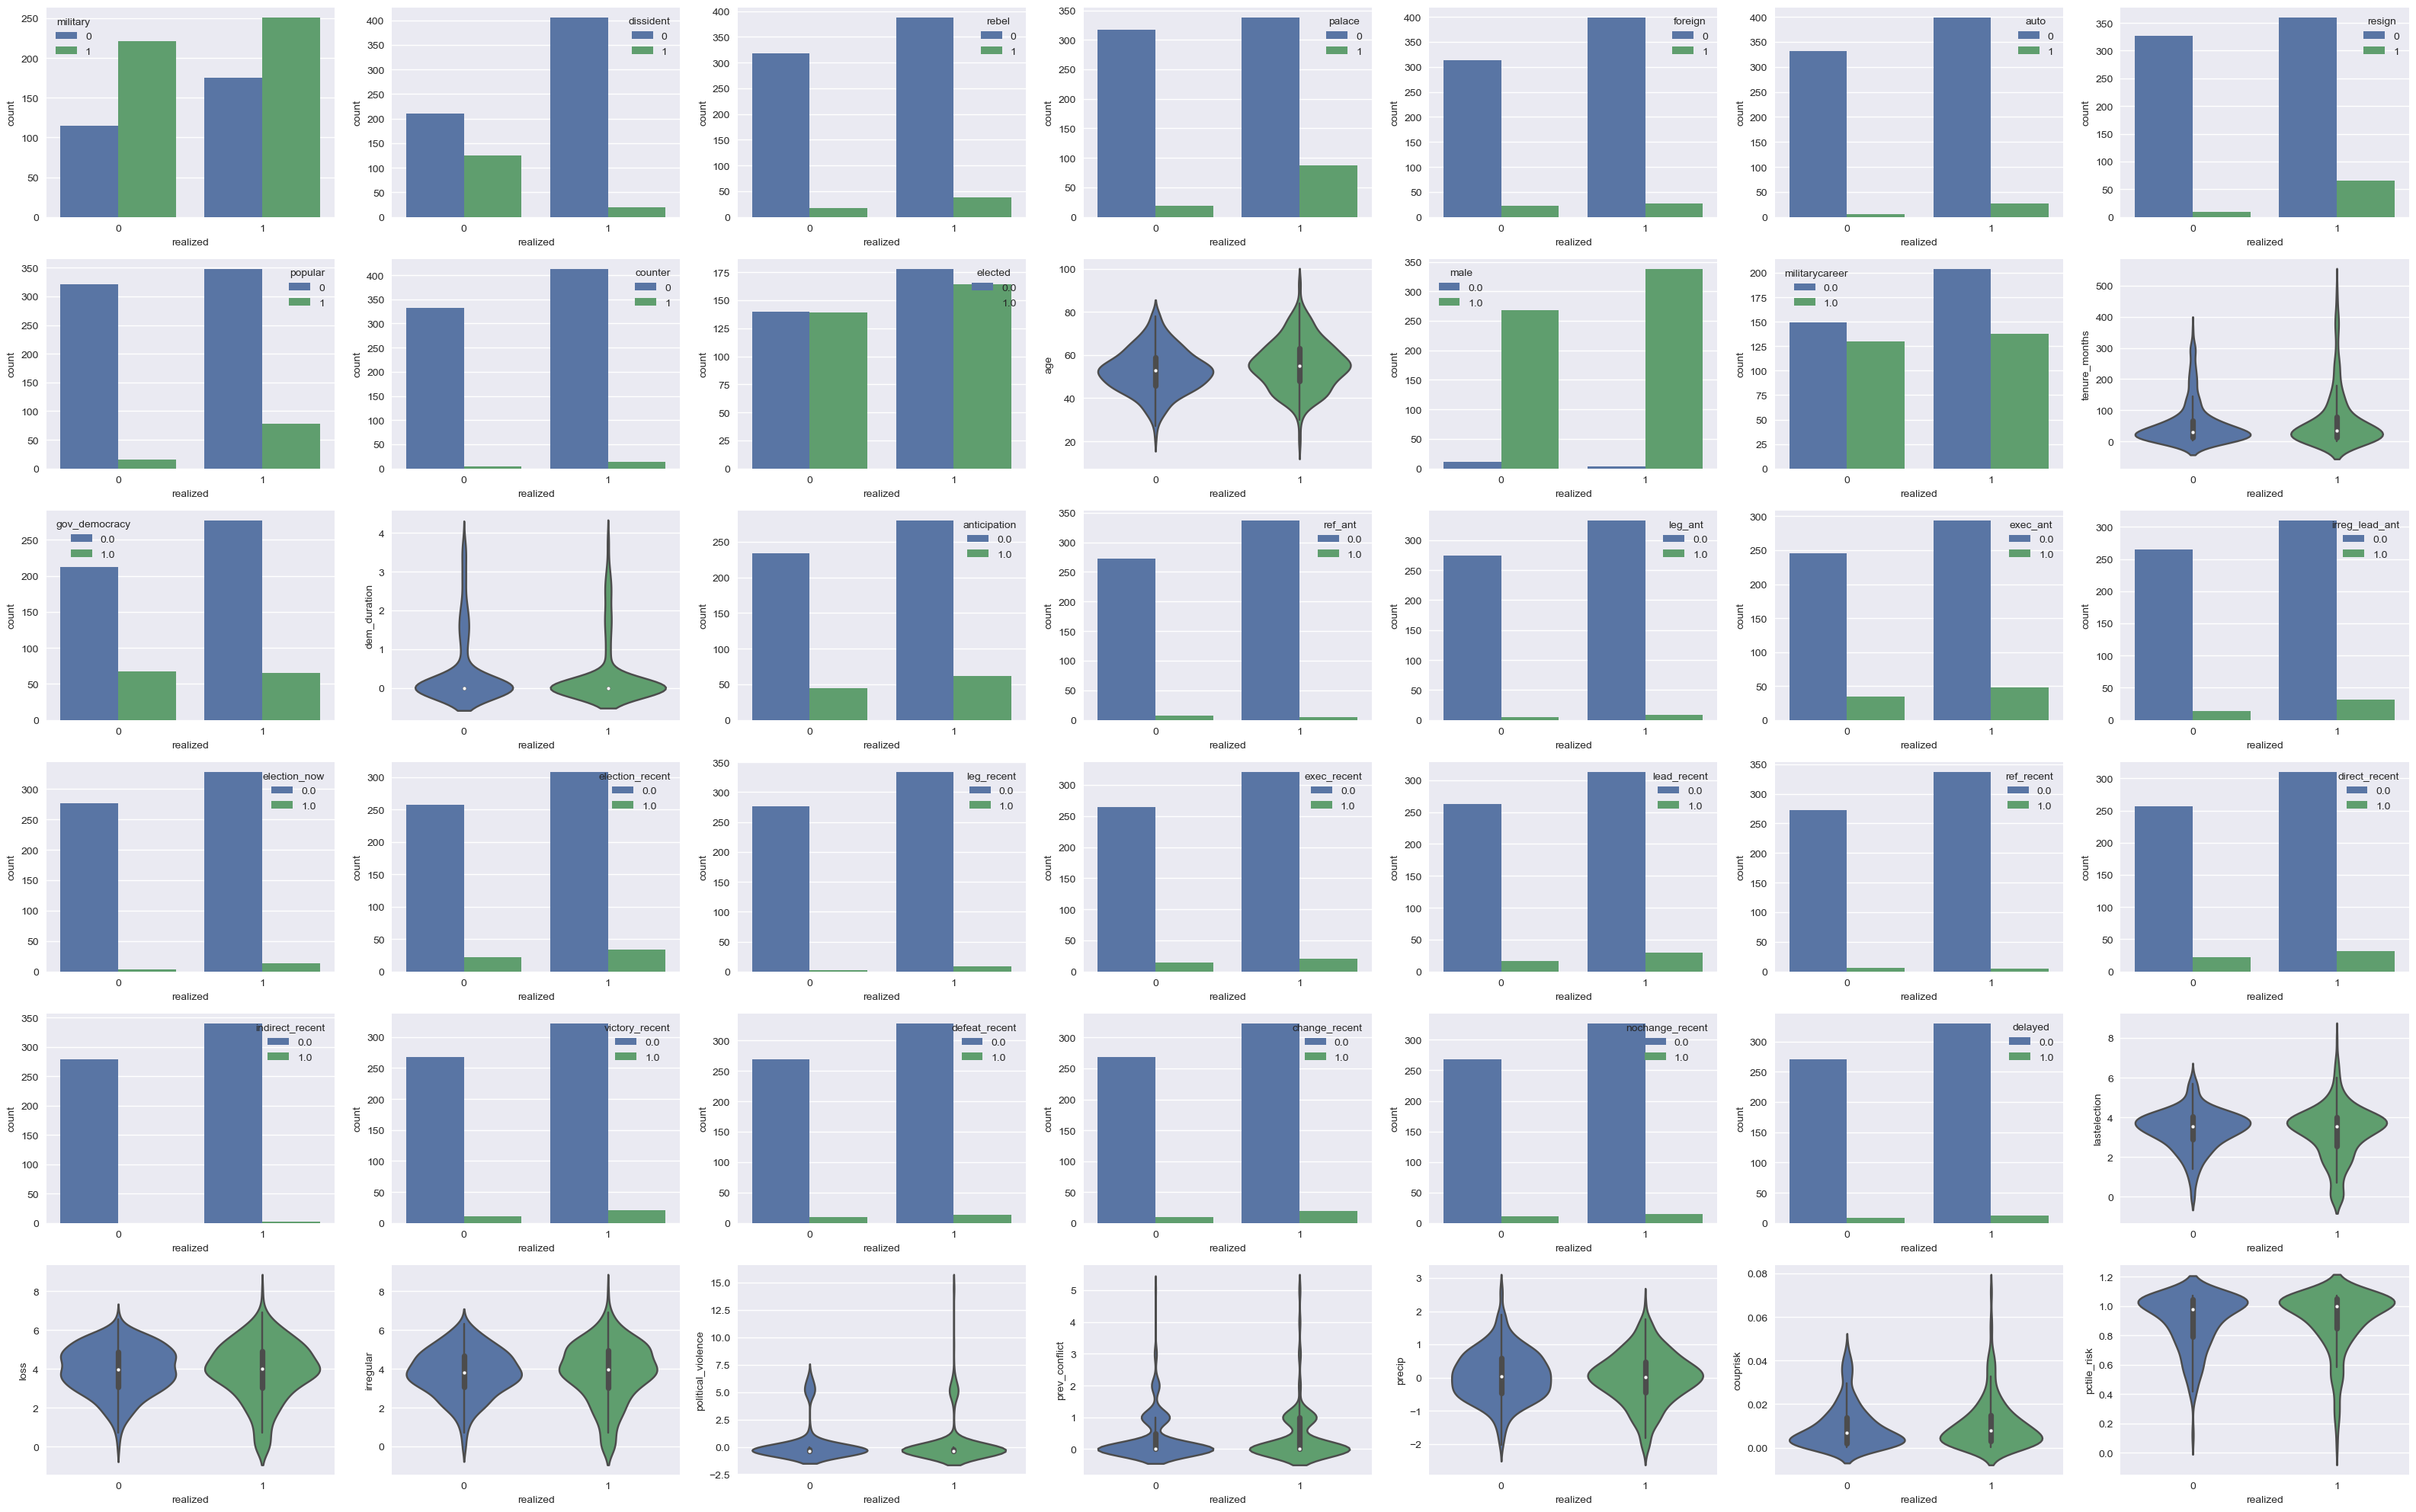

In [299]:
_,axss = plt.subplots(6,7, figsize=[40,25])
for i in range(6):
    for j in range(7):
        idx = i*7+j+7
        if idx > 48:
            break
        if len(set(unique_df.iloc[:,idx].dropna())) == 2:
            sns.countplot(x='realized',hue=unique_df.columns[idx],data=unique_df,ax=axss[i][j])
        else:
            sns.violinplot(x='realized',y=unique_df.columns[idx],data=unique_df,ax=axss[i][j])

From the first glance, we noticed that there are enormous features! It is good to know that we have a lot of information, but if we include all of these features into our models, it may lead to high dimensional data and the problem of overfitting. We may want to build models using only some selected features.

By the frequency histogram and the violin plots, it is hard to tell which feature may play a significant role in predicting the coup results. We noticed that data are distributed similary, while the only evident difference is the skewness of the numeric data. For instance, some realized coup observations happened when the political violence index was significantly higher or the leader's tenure period was longer. Although this may give us some insights concerning the data, we need to think critically about how to deal with the skewness. We may use tree-based models to fit our data, as they are relatively robost to outliers.

<a id="8"></a>
## Feature Engineering

<a id="9"></a>
### 1. Appending Additional Features

We hope to add more information to our dataset, so that it can show, at some particlar time point, how well the economy did in countries where coups took place. After careful research, we deem __oil price__ and __population growth rate__ are some ideal indicators of economic performance (while we also considered GDP-related features, these data are significantly missing for enormous countries, especially those where coups regularly happen, in the last century). Therefore, we want to add those information to our dataset.

To that end, we found some data from __Oxford University__ and __World Bank__.

In [300]:
cmo_df = pd.read_csv("https://raw.githubusercontent.com/sjwan01/coup-results-prediction-with-classification-models/main/data/CMO.csv")
ppl_df = pd.read_csv("https://raw.githubusercontent.com/sjwan01/coup-results-prediction-with-classification-models/main/data/population.csv")

In [301]:
cmo_df.head(3)

,Unnamed: 0,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
0,1960M01,1.63,..,1.63,..,..,..,0.14,0.4,..,...,511.47,11.42,715.40,206.1,2180.4,1631.0,260.8,35.27,83.5,0.91
1,1960M02,1.63,..,1.63,..,..,..,0.14,0.4,..,...,511.47,11.42,728.19,203.7,2180.4,1631.0,244.9,35.27,83.5,0.91
2,1960M03,1.63,..,1.63,..,..,..,0.14,0.4,..,...,511.47,11.42,684.94,210.3,2173.8,1631.0,248.7,35.27,83.5,0.91


In [302]:
ppl_df.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,107195.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,694665117.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,39835428.0


After examining these datasets, we notice that they have probably enormous missing values. The earliest records of commodity prices and national population trace back to 1960. However, the __CDP__ dataset records coup observations since 1945. Hence, we may need to address the missing values problem later.

Let's keep that in mind! Before doing that, we define a function, which allows us to create new columns `oil_price` and `population_growth` to our dataset and add values from the supplementary data as appropriate. If some data are unavailable, we assign their corresponding entries with `NA`s for now.

Notice, we want to add data concerning the __population growth rate__, but we only have the population data. Suppose we want to obtain the population growth rate in year $x$, we may do so using the following formula:

$$\mbox{population growth rate in }x=\frac{\mbox{population in }x-\mbox{population in }(x-1)}{\mbox{population in }(x-1)}.$$

We add the population growth rate in the preceding year when the coups happened, as when the coup is not yet ended, the population data of this year is unavailable. This also applies to the oil price data.

In [303]:
def add_features(d):
    
    c = d.copy() # make a copy to avoid destructive changes
    
    for i in range(0,len(c)): # iterate through coup observations
        str_country = c.loc[i,"country"]
        year = c.loc[i,"year"]
        month = c.loc[i,"month"]
        previous_year = str(year - 1)
        previous_pyear = str(year - 2)
        str_date = None
        
        if month < 10:
            str_date = previous_year + "M0" + str(month)
        else:
            str_date = previous_year + "M" + str(month)
            
        try: # if oil price of the country at some time is available, add it to c
            c.loc[i,"oil_price"] = cmo_df.loc[cmo_df.iloc[:,0]==str_date,"Crude oil, average"].values[0]
        except: pass # else, leave it blank
        
        try: # if population of the country at some time is available, add it to c
            population_pyear = ppl_df.loc[ppl_df["Country Name"]==str_country,previous_year].values[0]
            population_ppyear = ppl_df.loc[ppl_df["Country Name"]==str_country,previous_pyear].values[0]
            c.loc[i,"population_growth"] = (population_pyear - population_ppyear) / population_ppyear
        except: pass # else, leave it blank
        
    return c

Apply the function to our dataset, and explore the distribution of the `oil_price` and the `population_growth` data.

In [304]:
add_df = add_features(unique_df)
add_df.head(3)

,coup_id,cowcode,country,year,month,day,realized,military,dissident,rebel,...,government_Monarchy,government_Other,government_Parliamentary Democracy,government_Party-Personal,government_Personal Dictatorship,government_Presidential Democracy,government_Provisional - Civilian,government_nan,oil_price,population_growth
0,43910302014,439,Burkina Faso,2014,10,30,1,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.43,0.030266
1,51605132015,516,Burundi,2015,5,13,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,105.71,0.031865
2,48304132006,483,Chad,2006,4,13,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.64,0.037173


<Axes: xlabel='realized', ylabel='population_growth'>

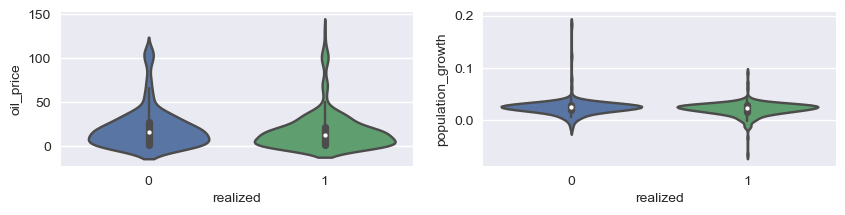

In [305]:
_,axss = plt.subplots(1,2, figsize=[10,2])
sns.violinplot(x='realized',y='oil_price',data=add_df,ax=axss[0])
sns.violinplot(x='realized',y='population_growth',data=add_df,ax=axss[1])

So far, we have all selected variables in our dataset, and we have also dropped redundant features. Thus, while `realized` is the target variable - as it tells whether a coup succeeded or not - and the first 6 columns are identifiers, the rest of the variables are our predictors.

<a id="10"></a>
### 2. Missing Values Imputation

In [306]:
from fancyimpute import IterativeImputer

To deal with the missing values in our dataset, we compute the number of missing entries for each observation and visualize it. If some rows have too many missing entries, it might be a good idea to just drop them. For the other rows with some missing entries, we may want to impute these values - so that information concerning other features will not be kept.

[Text(0.5, 0, 'Number of NAs')]

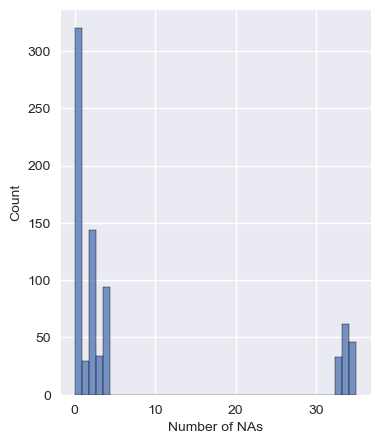

In [307]:
_,axss = plt.subplots(figsize=[4,5])
num_na_row = add_df.isnull().sum(axis=1)
sns.histplot(data=num_na_row).set(xlabel="Number of NAs")

Based on the frequency histograms, some observations have around 35 missing entries. These coup records provide us with too little information - so we just drop them. Why do some events have more than 35 missing entries? That is because information of some countries are not provided in the __REIGN__ dataset, and we already knew there are some `null`s in `couprisk` and `pctile_risk`. Then, the rest of the missing entries should come from the `oil_price` and the `population_growth_rate` columns.

We start with dropping observations with more than 30 missing entries and then print the number of missing entries for the features that have `null`s.

In [308]:
filtered_df = add_df[list(num < 30 for num in num_na_row)].reset_index(drop=True)

for feature in filtered_df.columns:
    num = filtered_df[feature].isnull().sum()
    if num != 0:
        txt = "{name} has {num} NAs."
        print(txt.format(name=feature, num=num))
        
print("\nThere are in total {num} observations in our dataset.".format(num=len(filtered_df)))

couprisk has 272 NAs.
pctile_risk has 272 NAs.
oil_price has 94 NAs.
population_growth has 157 NAs.

There are in total 621 observations in our dataset.


We may want to drop `couprisk` and `pctile_risk` because each has 272 missing entries - while in total there are 621 observations.

In [309]:
filtered_df = filtered_df.drop(['couprisk','pctile_risk'], axis=1)

We may not want to replace those missing values with means or medians, as that is very likely to change the distribution of our data significantly. Instead, we use the __multiple imputed chained equations (MICE)__ method. It counts for the "relationship" between the target feature and other features and meanwhile keeps the relative distribution similar before and after the imputation. After this, our dataset should be complete.

In [310]:
mice_imputer = IterativeImputer()
sliced_dp = filtered_df.iloc[:,6:]
array_imputed = mice_imputer.fit_transform(sliced_dp)
df_imputed = pd.DataFrame(array_imputed)

complete_df = filtered_df.copy()
complete_df[complete_df.columns[6:]] = df_imputed
complete_df.head(3)

,coup_id,cowcode,country,year,month,day,realized,military,dissident,rebel,...,government_Monarchy,government_Other,government_Parliamentary Democracy,government_Party-Personal,government_Personal Dictatorship,government_Presidential Democracy,government_Provisional - Civilian,government_nan,oil_price,population_growth
0,43910302014,439,Burkina Faso,2014,10,30,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,105.43,0.030266
1,51605132015,516,Burundi,2015,5,13,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,105.71,0.031865
2,48304132006,483,Chad,2006,4,13,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.64,0.037173


We also explored the ratio of the realized coup observations.

In [311]:
print("There are {ratio:.2f} realized coup instances.".format(ratio=complete_df["realized"].sum()/len(complete_df)))

if not complete_df.isnull().values.any():
    print("There is no missing values in our dataset.")

There are 0.55 realized coup instances.
There is no missing values in our dataset.


It turns out that the realized and unrealized instances are fairly balanced, so there is no need to oversample any category.

<a id="11"></a>
### 3. Feature Selection

In [312]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

As we have already noticed - there are tons of features could be used as predictors in our data. Including all features in our model will add dimensionality to the data and thus lead to overfitting. To avoid this, we have to select only some of these features as our predictors.

In [313]:
print("There are {num} features.".format(num=len(complete_df.columns)-6))

There are 54 features.


What features are desirable? Look back to the questions we asked in the problem statement, we may want our predictors to be crucial in the predictive sense. Thus, one way for us to obtain such predictors is to use predictive machine learning models embedded with feature selection methods.

Because our predictive question is whether a coup will succeed or not, the classification models will be our solution. While choosing which model(s) to use, we also consider the outliers. Therefore, we will fit a __Decision Tree__ and a __Random Forest__ model to our data.

Why are these models appropriate?

The first reason is that tree-based models, unlike Gaussian ones, are robust to outliers, as they do not require assumptions regarding the distribution, and therefore, skewness should not be our concern. Secondly, the decision tree and the random forest model both allow us to quantify feature importance. Altogether, these characteristics make the decision tree and the random forest model particularly appealing.

We at first extract __$X$__ and __$y$__ from our data and split them into the training and the test sets. Assume all features except for the idenfitiers are our predictors for now. Then, we fit our data to a decision tree and a random forest model, respectively, with default hyperparameters.

In [314]:
X = complete_df.iloc[:,7:]
y = complete_df["realized"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=214)

default_dt = DecisionTreeClassifier(random_state=123)
default_rf = RandomForestClassifier(random_state=245)

We at first fit the decision tree and use accuracy as the evaluation metric for now.

In [315]:
default_dt.fit(X_train, y_train)
accuracy_score(default_dt.predict(X_test), y_test)

0.5686695278969958

The same step applies to the random forest model. Notice that the data is of extremely high dimensionality now. We avoid overfitting by feature selection, and later, we can compare whether our models can yield similar or better performance with much fewer predictors.

In [316]:
default_rf.fit(X_train, y_train)
accuracy_score(default_rf.predict(X_test), y_test)

0.6845493562231759

After fitting the models, we rank and visualize the predictors by their importance scores under both the decision tree and the random forest model. It turns out that only a portion of the features contribute to predicting the coup results.

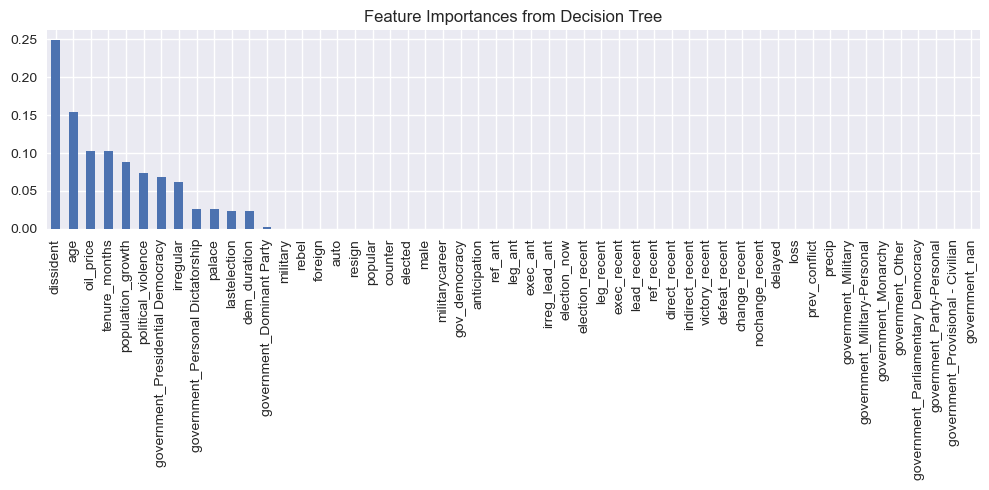

In [317]:
dt_import_dict= {}
for col, val in sorted(zip(X_train.columns, default_dt.feature_importances_),
                       key=lambda x:x[1],reverse=True):
  dt_import_dict[col]=val
tree_importances = pd.Series(dt_import_dict.values(), index=dt_import_dict.keys())
fig, ax = plt.subplots(figsize=[10,5])
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances from Decision Tree")
fig.tight_layout()

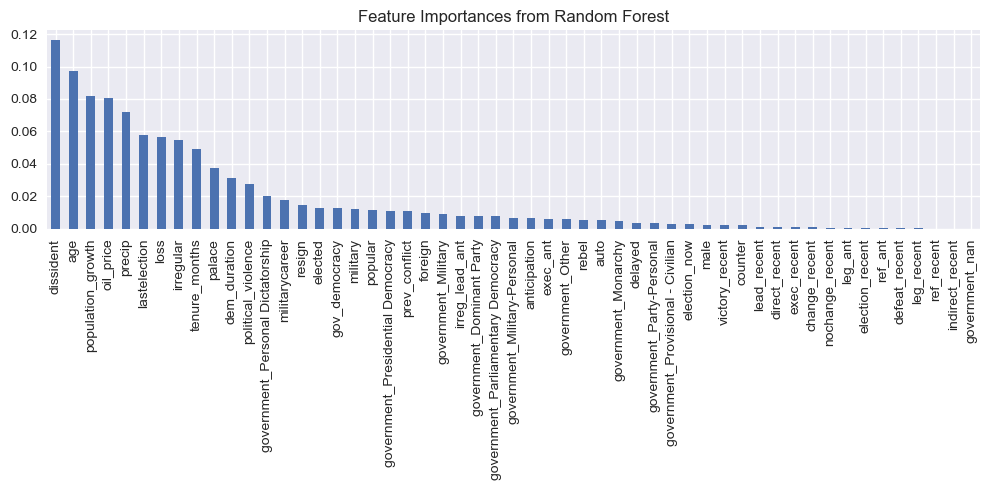

In [318]:
rf_import_dict= {}
for col, val in sorted(zip(X_train.columns, default_rf.feature_importances_),
                       key=lambda x:x[1],reverse=True):
  rf_import_dict[col]=val
forest_importances = pd.Series(rf_import_dict.values(), index=rf_import_dict.keys())
fig, ax = plt.subplots(figsize=[10,5])
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances from Random Forest")
fig.tight_layout()

Therefore, from each model, we select the top 15 features with the highest importance scores. By this step, we will have two lists of features. We further compare the two lists to find a set of features that both models deem important, and eventually, these will be the predictors selected.

We stored them into `features` and print them out.

In [319]:
dt_features = tree_importances.keys()[:10].tolist()
rf_features = forest_importances.keys()[:10].tolist()
features = list(set(dt_features).intersection(rf_features))
print(features)

['population_growth', 'oil_price', 'tenure_months', 'age', 'palace', 'dissident', 'irregular']


Finally, we can start to build models using the selected predictors.

<a id="12"></a>
## Data Modeling

In [320]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<a id="13"></a>
### 1. Model Training and Evaluation

We start with splitting our data into the training and the test sets with a ratio of 0.7.

In [321]:
X = complete_df[features]
y = complete_df["realized"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=345)

Then, we load a decision tree and a random forest classifier. We set their hyperparameters as default.

In [322]:
default_dt = DecisionTreeClassifier(random_state=328)
default_rf = RandomForestClassifier(random_state=546)

Before fitting our models, we at first define a function that could help us evaluate the performance of our models with some basic metrics for classification tasks. The following function will print out the accuracy, precision, recall, and F1 scores of a model and plot out the confusion matrix.

In [323]:
def eval_matrices(X_test, y_test, model):
    predictions = model.predict(X_test)
    print("Accuracy Scores: {score}.".format(score=accuracy_score(predictions, y_test)))
    print("Precision Scores: {score}.".format(score=precision_score(predictions, y_test)))
    print("Recall Scores: {score}.".format(score=accuracy_score(predictions, y_test)))
    print("F1 Scores: {score}.".format(score=f1_score(predictions, y_test)))
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    _,axss = plt.subplots(figsize=[4,3])
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='')

What do these metrics mean under this particular context?

A high accuracy means our models can make a good number of correct predictions, a high precision score means our models make fewer mistakes while predicting successful coups, and a high recall score means our models make fewer mistakes while predicting failed coups - while a higher F1 score would mean our models yield high precision and recall scores.

Although accuracy will not be a bad option of metrics since our data is fairly balanced, it is definitely useful to look at the other metrics as well. For instance, politicians might be interested in the precision score as well, because they hope to rightly predict more successful coups so that they could prepare for dealing with the new regime, and it does not matter if in fact failed coup instances are expected to be successful. Investors, however, will be the opposite.

Then, we apply this function to both the default decision tree and the default random forest model. We take a look at the metric information.

Accuracy Scores: 0.5839080459770115.
Precision Scores: 0.5208333333333334.
Recall Scores: 0.5839080459770115.
F1 Scores: 0.5800464037122971.


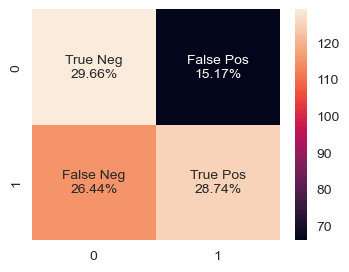

In [324]:
default_dt.fit(X_train, y_train)
eval_matrices(X_test, y_test, default_dt)

Accuracy Scores: 0.6781609195402298.
Precision Scores: 0.7375.
Recall Scores: 0.6781609195402298.
F1 Scores: 0.7165991902834008.


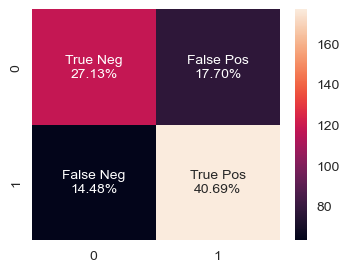

In [325]:
default_rf.fit(X_train, y_train)
eval_matrices(X_test, y_test, default_rf)

It is obvious that the random forest model is making better predictions here. While all scores are around 50-60% for the decision tree model, those for the random forest model are around 70%. It is also worth noticing that we maintained similar accuracy scores comparing to the models fit without feature selection. This shows that our predictors are representative enough for the observations.

<a id="14"></a>
### 2. Hyperparameter Tuning

In [326]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve

The models we fit used default hyperparameters. Now, we want to tune these hyperparameters using `RandomizedSearchCV`. Although it does not explore all combinations of hyperparameters given, `RandomizedSearchCV` is much less time-consuming comparing to `GridSearchCV`. Among the 4 evaluation metrics for classification models, we still choose the accuracy score as the target metric to be optimized.

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Accuracy Scores: 0.6896551724137931.
Precision Scores: 0.95.
Recall Scores: 0.6896551724137931.
F1 Scores: 0.7715736040609137.


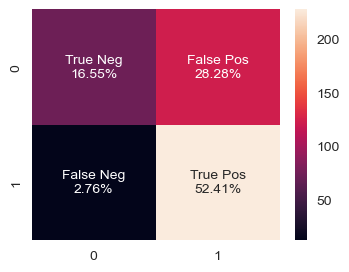

In [327]:
tuned_dt = DecisionTreeClassifier(random_state=328)

dt_parameters = {
    'max_depth' : [10,30,50,70,90,110],
    'criterion' : ['gini','entropy'],
    'max_depth' : [3,5,7,9,11],
    'max_features' : ['sqrt','log2'],
    'min_samples_split' : [2,4,6,8,10]
}

dt_rand_search = RandomizedSearchCV(estimator=tuned_dt, param_distributions=dt_parameters, 
                                    cv=10, verbose=1, scoring='accuracy', random_state=111)

dt_rand_search.fit(X_train, y_train)
eval_matrices(X_test, y_test, dt_rand_search)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Accuracy Scores: 0.696551724137931.
Precision Scores: 0.7916666666666666.
Recall Scores: 0.696551724137931.
F1 Scores: 0.7421875.


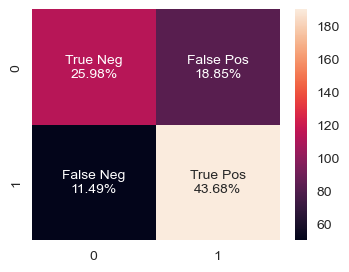

In [328]:
tuned_rf = RandomForestClassifier(random_state=548)

rf_parameters = {
    'n_estimators' : [10,30,50,70,90,110],
    'max_features' : ['sqrt','log2'],
    'max_depth' : [3,5,7,9,11],
    'min_samples_split' : [2,4,6,8,10],
    'bootstrap' : [True,False]
}

rf_rand_search = RandomizedSearchCV(estimator=tuned_rf, param_distributions=rf_parameters,
                                    cv=10, verbose=1, scoring='accuracy', random_state=413)
rf_rand_search.fit(X_train, y_train)
eval_matrices(X_test, y_test, rf_rand_search)

We found that the hyperparameter tuning did improve the performance of our models, especially the decision tree.  Now, both models obtained an approximately 70% accuracy score. Such accuracy scores are not so promising, probably due to the limited number of observations in our dataset (600+). We can see, although the random forest model has a slightly higher accuracy score, the decision tree is better at predicting a particular category as it has better precision as well as recall scores, and its precision score is particularly outstanding.

To compare the model efficiency more visually, we plot out the ROC AUC curves below. Recall, the higher the AUC, the better the model's performance at distinguishing between the positive and negative classes. As we can tell from the graph below, the random forest model has a higher efficiency.

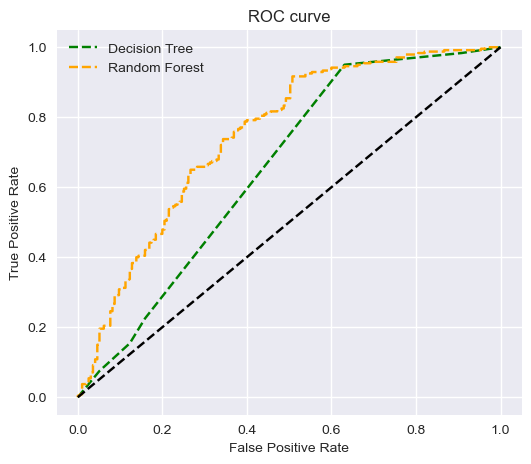

In [329]:
pred_prob_dt = dt_rand_search.predict_proba(X_test)
pred_prob_rf = rf_rand_search.predict_proba(X_test)

fpr1, tpr1, _ = roc_curve(y_test, pred_prob_dt[:,1], pos_label=1)
fpr2, tpr2, _ = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)

fig, ax = plt.subplots(figsize=[6,5])
plt.plot(fpr1, tpr1, linestyle='--', color='green', label='Decision Tree')
plt.plot(fpr2, tpr2, linestyle='--', color='orange', label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()